## 黑盒攻击

## 基于MCMC采样对项目本模型进行黑盒攻击

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import random
import pickle
import datetime

def attack_mcmc(data, target, model, device, max_step = 200, std = 0.02, thres_d = 0.05):
    attack_target = (target + 1) % 10
    for i in range(max_step):
        # transition
        # data_new = torch.normal(data, std=std).to(device)
        u = torch.rand(1, device=device)
        data_new = torch.normal(data, std=std).to(device)
        with torch.no_grad():
            pred = F.softmax(model(data_new), dim=-1)
        y_prime = pred[0][attack_target]
        if y_prime >= u:
            continue
        # print(f"l1-loss: \r{F.l1_loss(data_new, data, reduction='mean')}")
        if F.l1_loss(data_new, data, reduction='mean') > thres_d:
            continue
        data = data_new
        label = model(data).max(1, keepdim=True)[1]
        if label == attack_target:
            print(f"attack success at step {i}, init label: {target.item()} current label: {label.item()}")
            return True, data
    return False, data

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
test_data = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, num_workers=8)

# 设置加速
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
# 加载模型
model = torchvision.models.resnet34(weights=None, num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层
model.load_state_dict(torch.load('../checkpoints/checkpoint-60-93.71.pt', map_location=device))
model.to(device)

success_num = 0
correct = 0
adv_examples = []
model.eval()

for (img, label) in test_loader:
    img = img.to(device)
    label = label.to(device)
    output = model(img)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != label.item():
        continue
    correct = correct + 1
    if correct > 1500:
        break
    res, attack_img = attack_mcmc(img, label, model, device, max_step=300, std=0.02, thres_d=0.05)
    if res:
        adv_examples.append((img.cpu().detach().numpy().squeeze(), attack_img.cpu().detach().numpy().squeeze(), label.item()))
        success_num = success_num + 1
    if correct % 100 == 0:
        print(f"correct: {correct} success: {success_num}")
# 输出攻击成功率
print(f"attack success radio: {success_num / 1500}")
current_time = datetime.datetime.now()
with open(f"../attack_data/ResNet-black-MCMC-{current_time.strftime('%H-%M')}.pkl", 'wb') as f:
    pickle.dump(adv_examples, f)

cuda
attack success at step 5, init label: 7 current label: 8
attack success at step 27, init label: 7 current label: 8
attack success at step 13, init label: 7 current label: 8
attack success at step 23, init label: 7 current label: 8
attack success at step 7, init label: 7 current label: 8
attack success at step 67, init label: 7 current label: 8
attack success at step 22, init label: 7 current label: 8
attack success at step 15, init label: 7 current label: 8
attack success at step 4, init label: 7 current label: 8
attack success at step 6, init label: 7 current label: 8
correct: 100 success: 10
attack success at step 58, init label: 7 current label: 8
attack success at step 50, init label: 7 current label: 8
attack success at step 15, init label: 7 current label: 8
attack success at step 10, init label: 7 current label: 8
attack success at step 63, init label: 7 current label: 8
attack success at step 6, init label: 9 current label: 0
correct: 200 success: 16
attack success at step

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
146


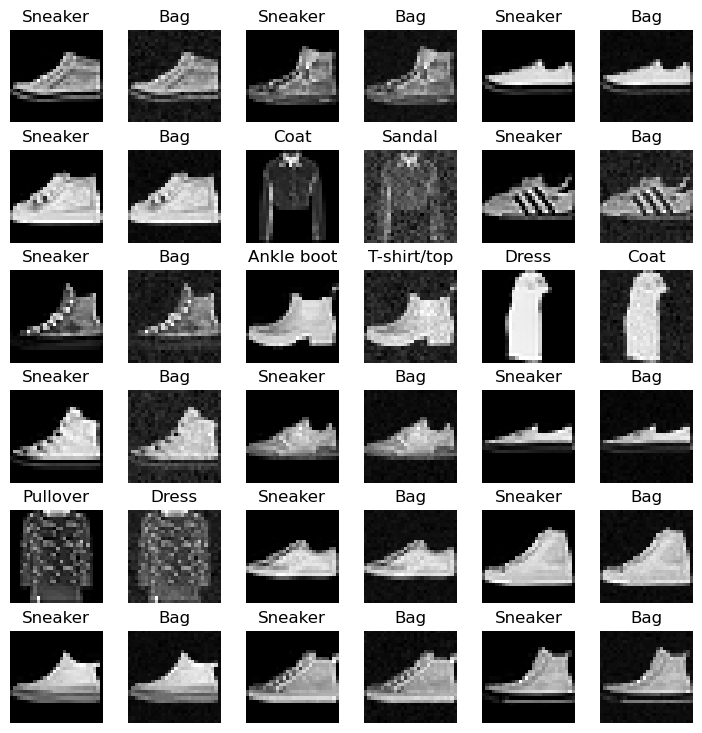

In [8]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torchvision
import numpy as np
import random
import pickle

# 加载测试集类别
test_data = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())
class_names = list(test_data.classes)
print(class_names)

adv_examples = []
with open(f"../attack_data/ResNet-black-MCMC-17-30.pkl", 'rb') as f:
    adv_examples = pickle.load(f)
print(len(adv_examples))
random.seed(2023)
random.shuffle(adv_examples)

torch.manual_seed(2023)
fig = plt.figure(figsize=(9, 9))
rows, cols = 6, 6
cnt = 1
for i, (data, perturbed_data, target) in enumerate(adv_examples):
    if cnt > rows * cols:
        break
    random_idx = target
    fig.add_subplot(rows, cols, cnt)
    plt.imshow(data, cmap="gray")
    plt.title(class_names[random_idx])
    plt.axis(False)
    # plt.imsave(f'../images/White-N{cnt // 2}-Original-{random_idx}-{class_names[random_idx]}.png', data.cpu().detach().numpy().squeeze())
    cnt += 1

    fig.add_subplot(rows, cols, cnt)
    plt.imshow(perturbed_data, cmap="gray")
    attack_target = (random_idx + 1) % 10
    plt.title(class_names[attack_target])
    plt.axis(False)
    # plt.imsave(f'../images/White-N{(cnt-1) // 2}-Perturbed-{attack_target}-{class_names[attack_target]}.png', perturbed_data.cpu().detach().numpy().squeeze())
    cnt += 1
fig.subplots_adjust(hspace=0.3, wspace=0.1)